# Reset

In [1]:
%reset -f

# Import

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import datetime
from PIL import Image

# Image loading and preprocessing

In [3]:
# convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((256, 256)), # (128, 128) 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Values of ImageNet  
])

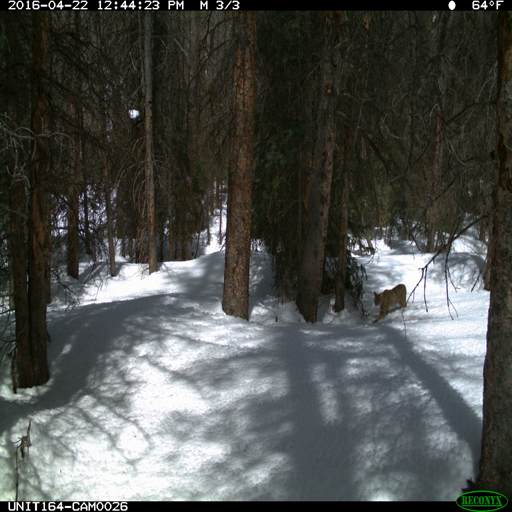

In [4]:
# Example image
img = Image.open('/exchange/dspro01/group3/data/train/bobcat/2015_Unit164_Ivan026_img0171.jpg')
img_small = img.resize((512, 512))
img_small

In [5]:
img_transformed = transform(img)

def denormalize(tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

to_pil = transforms.ToPILImage()

denormalized_image = to_pil(denormalize(img_transformed.clone()))


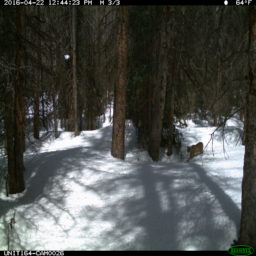

In [6]:
denormalized_image

In [7]:
# For reproducibility of Transformation
seed = 42
torch.manual_seed(seed)

In [8]:
data_dir = '/exchange/dspro01/group3/data/train' 
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name
# Normalization independent of dataset so applied at root

In [9]:
num_classes = 12  # number of categories
num_epochs =  25
learning_rate = 0.001 
batch_size = 32

In [10]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)     


## Split data

In [11]:
generator = torch.Generator().manual_seed(seed) # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

In [67]:
len(train_dataset) == (2400 * 12 * 0.8) # Safety check

True

## Load data

In [38]:
# Divides into batches, shuffles data, load in parallel
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [39]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}


In [40]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Model loading and transfer learning

In [14]:
from torchvision import models
import torch.nn as nn

## Load model

In [15]:
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features # Retrieves the number of input features from the current final layer (fc) of the model
model.fc = nn.Linear(num_features, num_classes) # Replaces the existing final layer with a new nn.Linear layer. Full connected - could add more layers

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss function suiting classification problems

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
# Initial learning rate of 0.001
# weight_decay corresponds to the L2 regularization. Prevents overfitting by penalizing large weight values.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
# optim = type of learning rate being used
# optimizer = optimizer whose learning rates are being adjusted
# Step size = number of epochs between parameters adjustments
# gamma = The factor by which the learning rate is reduced at each step.

In [17]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training & Validation loop

In [46]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
import numpy as np
import torch

# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_labels = []
val_predictions = []

# Initialize variables to track the best model
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_val_accuracy = 0.0
best_model_path = f'best_model_{current_time}.pth'


# Track classification metrics
val_f1_scores = []
val_recall = []
val_precision = []
val_conf_matrices = []

# Early Stopping Parameters
patience = 5  # Number of epochs to wait before stopping
early_stopping_counter = 0  # Counter to track how long since the last improvement
best_epoch = 0  # To track the epoch with the best performance

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train() # Set model to training mode
        else:
            model.eval()  # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0 # number of correct per epoch
        all_preds = []
        all_labels = []

        # Iterate over batches
        for inputs, labels in dataloaders[phase]:
            # Move data to the device GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Resets the gradients of all parameters to zero before the backward pass.
            optimizer.zero_grad()

            # Forward pass    
            with torch.set_grad_enabled(phase == 'train'):# if train phase, set gradient
                outputs = model(inputs) # Passes the input in the Resnet model
                # outputs contains the raw predictions of the model for each input
                
                _, preds = torch.max(outputs, 1)
                # Returns the maximum from the outputs, with dimension 1 and a slot for each class
                # Returns 2 tensors: maximum value and its index
                # _ discards the maximum value 
                # Only the index is kept in preds
                
                loss = criterion(outputs, labels)
                # Computes loss function between outputs and labels
                # Refers to the CrossEntropy loss function defined above

                #  Backpropagation and update the model parameters during training.
                if phase == 'train':
                    loss.backward()
                    optimizer.step() # in which direction to go - -gradient

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        # Convert lists to numpy arrays for metric calculations
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics for later plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_predictions.append(all_preds)
            val_labels.append(all_labels)
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Calculate F1-Score, and confusion matrix for validation phase
            f1 = f1_score(all_labels, all_preds, average='weighted') # from sklearn
            recall = recall_score(all_labels, all_preds, average="weighted")
            precision = precision_score(all_labels, all_preds, average="weighted")
            
            val_f1_scores.append(f1)
            val_recall.append(recall)
            val_precision.append(precision)

            # Confusion Matrix
            conf_matrix = confusion_matrix(all_labels, all_preds)
            val_conf_matrices.append(conf_matrix)

            # Save the best model based on validation accuracy
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_epoch = epoch + 1
                early_stopping_counter = 0  # Reset the counter
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'accuracy': best_val_accuracy,
                }, best_model_path)
                torch.save(model.state_dict(), f'only_{best_model_path}')
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1  # Increment the counter

    scheduler.step()

    # Check early stopping condition
    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        print(f'Best validation accuracy achieved at epoch {best_epoch}: {best_val_accuracy:.4f}')
        break

print('Training complete')


Epoch 1/25
----------
train Loss: 0.7549 Acc: 0.7302
val Loss: 1.8887 Acc: 0.5434
Saved best model at epoch 1 with validation accuracy: 0.5434
Epoch 2/25
----------
train Loss: 0.6413 Acc: 0.7733
val Loss: 0.6721 Acc: 0.7625
Saved best model at epoch 2 with validation accuracy: 0.7625
Epoch 3/25
----------
train Loss: 0.5580 Acc: 0.8063
val Loss: 0.8244 Acc: 0.7142
Epoch 4/25
----------
train Loss: 0.4972 Acc: 0.8258
val Loss: 0.7123 Acc: 0.7486
Epoch 5/25
----------
train Loss: 0.4422 Acc: 0.8475
val Loss: 0.5786 Acc: 0.7983
Saved best model at epoch 5 with validation accuracy: 0.7983
Epoch 6/25
----------
train Loss: 0.2346 Acc: 0.9224
val Loss: 0.3494 Acc: 0.8833
Saved best model at epoch 6 with validation accuracy: 0.8833
Epoch 7/25
----------
train Loss: 0.1609 Acc: 0.9476
val Loss: 0.3483 Acc: 0.8842
Saved best model at epoch 7 with validation accuracy: 0.8842
Epoch 8/25
----------
train Loss: 0.1168 Acc: 0.9629
val Loss: 0.3624 Acc: 0.8839
Epoch 9/25
----------
train Loss: 0.084

### Save values

In [47]:
import pandas as pd

# Create a dictionary for data
data = {
    "epoch": range(1, len(train_losses) + 1),  # Epochs start from 1
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "val_f1_score": val_f1_scores,
    "val_recall": val_recall,
    "val_precision": val_precision,
    "val_conf_matrix": val_conf_matrices,
    "val_labels": val_labels, #
    "val_predictions": val_predictions #
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
file_name = f"training_results_{current_time}.csv"
df.to_csv(file_name, index=False)


# Visualization of training results

In [48]:
len(train_losses)

23

Best validation accuracy: 0.8929 (Epoch 18)
Final accuracy gap (train - val): 0.1069


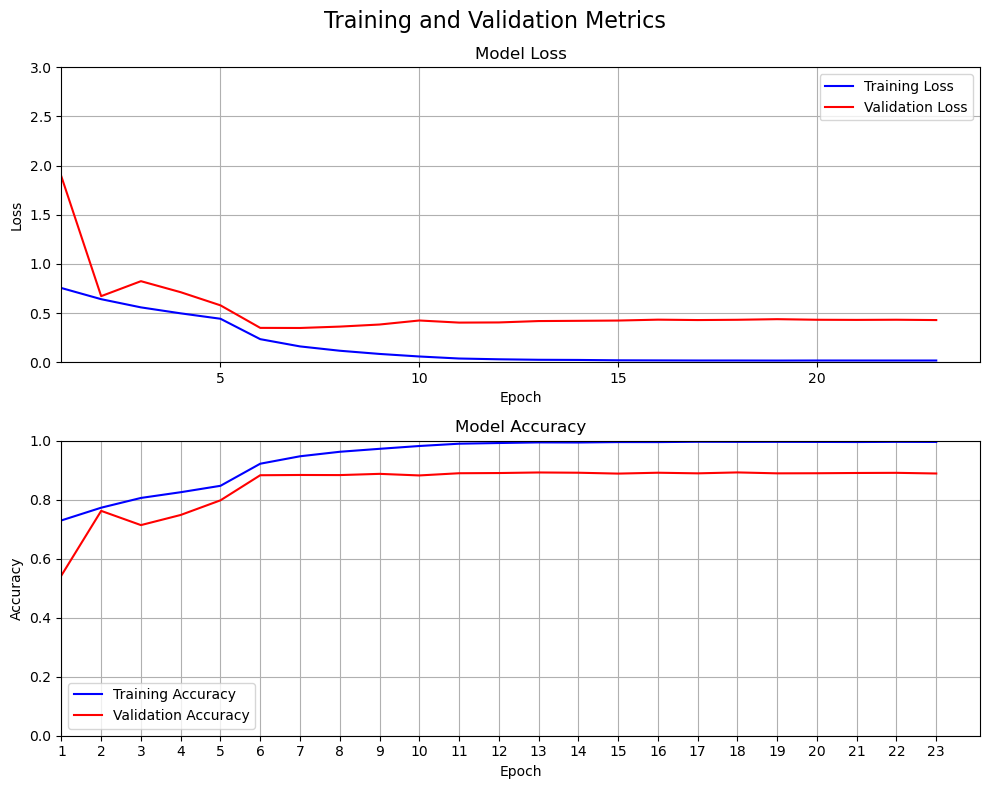

In [49]:
import matplotlib.pyplot as plt
import numpy as np

stopped_epoch = best_epoch + patience

# Data from training output
epochs = range(1, stopped_epoch+1)
           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 3)
ax1.set_xlim(1)
ax1.legend()
ax1.grid()


# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xlim(1)
ax2.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1))
ax2.legend()
ax2.grid()

# Adjust layout and display the plot
fig.tight_layout()
ax1.plot()
ax2.plot()
fig.show()

# Calculate and print best validation accuracy
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


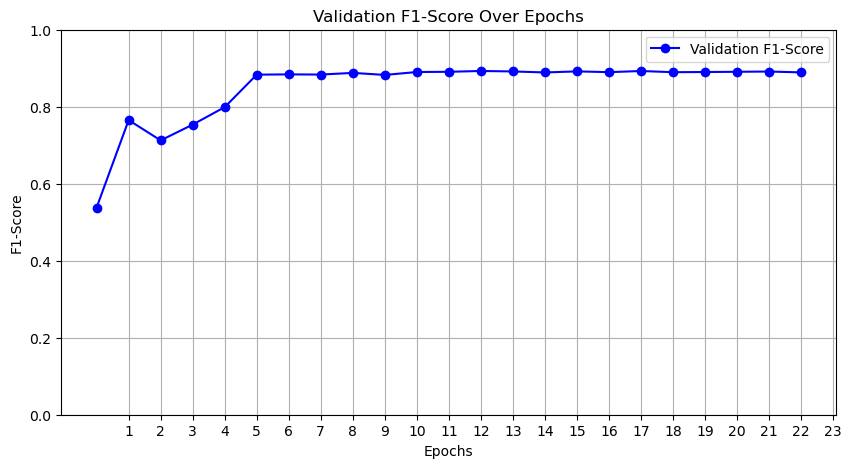

In [50]:
# Plot F1-Score
f, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot(val_f1_scores, label='Validation F1-Score', marker='o', color='blue')
ax.set_xlabel('Epochs', loc='center')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Over Epochs')
ax.set_ylim(0, 1)
ax.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1))
ax.legend()
ax.grid()
f.show()

18


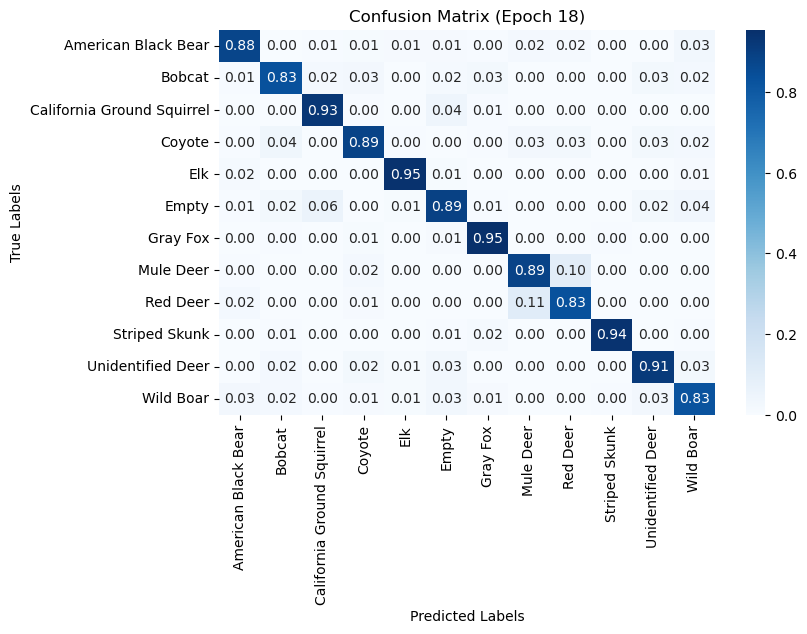

In [51]:
import seaborn as sns
print(best_epoch)
# Confusion Matrix for the Best Epoch
conf_matrix = val_conf_matrices[best_epoch - 1]  # Index corresponds to the best epoch
class_names = sorted(['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar'])

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ (len(val_dataset)/num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()


# Testing

Test set contains 600 pictures per category

In [18]:
test_dataset = datasets.ImageFolder(root='/exchange/dspro01/group3/data/test', transform=transform) # same transform as train and validation phases
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Load subset of test images for debugging

In [ ]:
from torch.utils.data import Subset

subset_indices = list(range(50))
test_subset = Subset(test_dataset, subset_indices)

# Create a DataLoader for the subset
test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


## Load trained model and Resnet model

Modify the model to train

In [19]:
import torch
import torchvision.models as models
import torch.nn as nn
best_model_only = 'only_best_model_2025-01-13_09-42-00.pth'#f'only_{best_model_path}' #'only_best_model_2025-01-04_11-05-04.pth' #  
# Load the pre-trained ResNet model
model = models.resnet50(pretrained=False)

# Modify the 'fc' layer to have 12 output classes
model.fc = nn.Linear(model.fc.in_features, 12)

model.load_state_dict(torch.load(best_model_only, map_location=torch.device('cpu')))
model.eval()


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
class_names = sorted(['American Black Bear', 'California Ground Squirrel', 
               'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 
               'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 
               'Striped Skunk', 'Wild Boar'])
class_mapping = {i: class_names[i] for i in range(12)}

## Model on one picture of the test set

In [56]:
image_path = '/exchange/dspro01/group3/data/test/bobcat/2015_Unit097_Ivan076_img0742.jpg'
#image_path = '/exchange/dspro01/group3/data/test/gray fox/CA-01_08_13_2015_CA-01_0001873.jpg' #2nd example
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image).unsqueeze(0) # Add batch dimension

In [57]:
# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    output = model(input_tensor)  # Forward pass
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted class: {predicted_class}")
print(f"Predicted class name: {class_mapping[predicted_class]}")


Predicted class: 3
Predicted class name: Coyote


## Model on all test set

In [ ]:
from tqdm import tqdm

all_labels = []
all_predictions = []

correct_predictions = 0
total_samples = 0

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in tqdm(test_loader, desc="Processing Batches", unit="batch"):
        print(f'Loop start')
        outputs = model(inputs)  
        predicted = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())  
        
        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        print('Label and prediction added to the lists')
    print('Testing done.')

# Compute accuracy
accuracy = correct_predictions / total_samples
print(f'Total Accuracy: {accuracy:.2%}')


Processing Batches:   0%|          | 0/225 [00:00<?, ?batch/s]

Loop start


Processing Batches:   0%|          | 1/225 [01:45<6:33:50, 105.49s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   1%|          | 2/225 [03:29<6:29:15, 104.74s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   1%|▏         | 3/225 [05:15<6:29:18, 105.22s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   2%|▏         | 4/225 [07:00<6:27:31, 105.21s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   2%|▏         | 5/225 [08:45<6:25:21, 105.10s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   3%|▎         | 6/225 [10:31<6:24:06, 105.24s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   3%|▎         | 7/225 [12:15<6:21:43, 105.06s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   4%|▎         | 8/225 [14:00<6:20:00, 105.07s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   4%|▍         | 9/225 [15:45<6:17:37, 104.89s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   4%|▍         | 10/225 [17:30<6:16:05, 104.96s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   5%|▍         | 11/225 [19:13<6:12:06, 104.33s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   5%|▌         | 12/225 [20:50<6:02:46, 102.19s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   6%|▌         | 13/225 [22:27<5:55:44, 100.68s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   6%|▌         | 14/225 [24:02<5:48:07, 98.99s/batch] 

Label and prediction added to the lists
Loop start


Processing Batches:   7%|▋         | 15/225 [25:38<5:43:18, 98.09s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   7%|▋         | 16/225 [27:15<5:40:07, 97.64s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   8%|▊         | 17/225 [28:51<5:37:05, 97.24s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   8%|▊         | 18/225 [30:29<5:35:44, 97.32s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   8%|▊         | 19/225 [32:05<5:33:10, 97.04s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   9%|▉         | 20/225 [33:42<5:31:12, 96.94s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:   9%|▉         | 21/225 [35:18<5:29:08, 96.81s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  10%|▉         | 22/225 [36:52<5:24:40, 95.96s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  10%|█         | 23/225 [38:23<5:17:09, 94.21s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  11%|█         | 24/225 [40:00<5:18:30, 95.07s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  11%|█         | 25/225 [41:37<5:19:08, 95.74s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  12%|█▏        | 26/225 [43:13<5:18:17, 95.97s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  12%|█▏        | 27/225 [44:50<5:17:07, 96.10s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  12%|█▏        | 28/225 [46:27<5:16:30, 96.40s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  13%|█▎        | 29/225 [48:04<5:15:52, 96.70s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  13%|█▎        | 30/225 [49:37<5:10:11, 95.44s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  14%|█▍        | 31/225 [51:12<5:08:44, 95.49s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  14%|█▍        | 32/225 [52:50<5:09:00, 96.06s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  15%|█▍        | 33/225 [54:28<5:09:21, 96.67s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  15%|█▌        | 34/225 [56:07<5:09:34, 97.25s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  16%|█▌        | 35/225 [57:41<5:05:43, 96.54s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  16%|█▌        | 36/225 [59:17<5:03:07, 96.23s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  16%|█▋        | 37/225 [1:00:53<5:01:30, 96.22s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  17%|█▋        | 38/225 [1:02:29<4:59:40, 96.15s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  17%|█▋        | 39/225 [1:04:05<4:58:01, 96.14s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  18%|█▊        | 40/225 [1:05:41<4:55:39, 95.89s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  18%|█▊        | 41/225 [1:07:15<4:52:35, 95.41s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  19%|█▊        | 42/225 [1:08:52<4:52:43, 95.98s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  19%|█▉        | 43/225 [1:10:29<4:52:20, 96.37s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  20%|█▉        | 44/225 [1:12:03<4:48:13, 95.54s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  20%|██        | 45/225 [1:13:38<4:46:08, 95.38s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  20%|██        | 46/225 [1:15:14<4:44:50, 95.48s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  21%|██        | 47/225 [1:16:50<4:43:53, 95.69s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  21%|██▏       | 48/225 [1:18:26<4:42:39, 95.82s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  22%|██▏       | 49/225 [1:20:02<4:40:52, 95.75s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  22%|██▏       | 50/225 [1:21:35<4:37:28, 95.13s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  23%|██▎       | 51/225 [1:23:12<4:36:49, 95.46s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  23%|██▎       | 52/225 [1:24:49<4:36:59, 96.07s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  24%|██▎       | 53/225 [1:26:24<4:34:33, 95.78s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  24%|██▍       | 54/225 [1:28:01<4:33:40, 96.02s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  24%|██▍       | 55/225 [1:29:43<4:37:44, 98.03s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  25%|██▍       | 56/225 [1:31:27<4:41:09, 99.82s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  25%|██▌       | 57/225 [1:33:14<4:45:01, 101.79s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  26%|██▌       | 58/225 [1:34:56<4:43:45, 101.95s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  26%|██▌       | 59/225 [1:36:40<4:43:55, 102.62s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  27%|██▋       | 60/225 [1:38:25<4:43:40, 103.16s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  27%|██▋       | 61/225 [1:40:10<4:43:57, 103.89s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  28%|██▊       | 62/225 [1:41:54<4:42:14, 103.89s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  28%|██▊       | 63/225 [1:43:40<4:42:17, 104.55s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  28%|██▊       | 64/225 [1:45:27<4:42:31, 105.29s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  29%|██▉       | 65/225 [1:47:11<4:39:10, 104.69s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  29%|██▉       | 66/225 [1:48:57<4:38:56, 105.26s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  30%|██▉       | 67/225 [1:50:42<4:36:30, 105.00s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  30%|███       | 68/225 [1:52:27<4:35:13, 105.18s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  31%|███       | 69/225 [1:54:12<4:33:01, 105.01s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  31%|███       | 70/225 [1:55:56<4:30:29, 104.71s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  32%|███▏      | 71/225 [1:57:39<4:27:25, 104.19s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  32%|███▏      | 72/225 [1:59:15<4:19:30, 101.77s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  32%|███▏      | 73/225 [2:00:51<4:13:11, 99.95s/batch] 

Label and prediction added to the lists
Loop start


Processing Batches:  33%|███▎      | 74/225 [2:02:28<4:09:22, 99.09s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  33%|███▎      | 75/225 [2:04:04<4:05:56, 98.37s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  34%|███▍      | 76/225 [2:05:40<4:02:13, 97.54s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  34%|███▍      | 77/225 [2:07:16<3:59:10, 96.96s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  35%|███▍      | 78/225 [2:08:53<3:57:48, 97.06s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  35%|███▌      | 79/225 [2:10:30<3:55:55, 96.95s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  36%|███▌      | 80/225 [2:12:05<3:53:06, 96.46s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  36%|███▌      | 81/225 [2:13:41<3:50:57, 96.23s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  36%|███▋      | 82/225 [2:15:19<3:51:02, 96.94s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  37%|███▋      | 83/225 [2:16:55<3:48:37, 96.60s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  37%|███▋      | 84/225 [2:18:29<3:44:57, 95.73s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  38%|███▊      | 85/225 [2:20:04<3:42:51, 95.51s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  38%|███▊      | 86/225 [2:21:38<3:40:42, 95.27s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  39%|███▊      | 87/225 [2:23:14<3:39:24, 95.40s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  39%|███▉      | 88/225 [2:24:50<3:38:01, 95.49s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  40%|███▉      | 89/225 [2:26:26<3:36:35, 95.55s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  40%|████      | 90/225 [2:28:01<3:34:37, 95.39s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  40%|████      | 91/225 [2:29:36<3:33:02, 95.39s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  41%|████      | 92/225 [2:31:10<3:30:23, 94.91s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  41%|████▏     | 93/225 [2:32:45<3:29:15, 95.12s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  42%|████▏     | 94/225 [2:34:20<3:27:20, 94.96s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  42%|████▏     | 95/225 [2:35:57<3:26:53, 95.48s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  43%|████▎     | 96/225 [2:37:33<3:25:37, 95.64s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  43%|████▎     | 97/225 [2:39:07<3:23:14, 95.27s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  44%|████▎     | 98/225 [2:40:41<3:20:46, 94.86s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  44%|████▍     | 99/225 [2:42:19<3:20:55, 95.68s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  44%|████▍     | 100/225 [2:43:52<3:17:46, 94.94s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  45%|████▍     | 101/225 [2:45:28<3:16:48, 95.23s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  45%|████▌     | 102/225 [2:47:06<3:17:13, 96.21s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  46%|████▌     | 103/225 [2:48:42<3:15:07, 95.96s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  46%|████▌     | 104/225 [2:50:18<3:13:33, 95.98s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  47%|████▋     | 105/225 [2:51:57<3:13:49, 96.91s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  47%|████▋     | 106/225 [2:53:32<3:11:11, 96.40s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  48%|████▊     | 107/225 [2:55:10<3:10:52, 97.06s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  48%|████▊     | 108/225 [2:56:46<3:08:38, 96.74s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  48%|████▊     | 109/225 [2:58:23<3:06:46, 96.61s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  49%|████▉     | 110/225 [2:59:53<3:01:46, 94.84s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  49%|████▉     | 111/225 [3:01:34<3:03:21, 96.51s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  50%|████▉     | 112/225 [3:03:18<3:05:52, 98.69s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  50%|█████     | 113/225 [3:05:01<3:06:55, 100.14s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  51%|█████     | 114/225 [3:06:48<3:08:46, 102.04s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  51%|█████     | 115/225 [3:08:34<3:09:12, 103.20s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  52%|█████▏    | 116/225 [3:10:17<3:07:25, 103.17s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  52%|█████▏    | 117/225 [3:12:02<3:07:04, 103.93s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  52%|█████▏    | 118/225 [3:13:49<3:06:46, 104.73s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  53%|█████▎    | 119/225 [3:15:33<3:04:47, 104.60s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  53%|█████▎    | 120/225 [3:17:20<3:03:56, 105.11s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  54%|█████▍    | 121/225 [3:19:04<3:02:04, 105.05s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  54%|█████▍    | 122/225 [3:20:48<2:59:19, 104.46s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  55%|█████▍    | 123/225 [3:22:32<2:57:33, 104.44s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  55%|█████▌    | 124/225 [3:24:18<2:56:36, 104.91s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  56%|█████▌    | 125/225 [3:26:01<2:53:59, 104.40s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  56%|█████▌    | 126/225 [3:27:48<2:53:26, 105.12s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  56%|█████▋    | 127/225 [3:29:31<2:50:33, 104.42s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  57%|█████▋    | 128/225 [3:31:07<2:44:40, 101.87s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  57%|█████▋    | 129/225 [3:32:44<2:41:02, 100.65s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  58%|█████▊    | 130/225 [3:34:14<2:34:06, 97.33s/batch] 

Label and prediction added to the lists
Loop start


Processing Batches:  58%|█████▊    | 131/225 [3:35:51<2:32:19, 97.23s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  59%|█████▊    | 132/225 [3:37:28<2:30:30, 97.10s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  59%|█████▉    | 133/225 [3:39:03<2:27:52, 96.44s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  60%|█████▉    | 134/225 [3:40:37<2:25:17, 95.80s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  60%|██████    | 135/225 [3:42:13<2:23:44, 95.83s/batch]

Label and prediction added to the lists
Loop start


Processing Batches:  60%|██████    | 136/225 [3:43:49<2:22:21, 95.97s/batch]

Label and prediction added to the lists


## Save test data as csv

In [ ]:
# Create a DataFrame
import pandas as pd
df = pd.DataFrame({
    'Label': all_labels,
    'Prediction': all_predictions
})

# Save the DataFrame to a CSV file
filename = f'predictions_model_{best_model_only[-23:-4]}.csv'
df.to_csv(filename, index=False)

## Plot data

In [ ]:
import numpy as np
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
accuracy = np.mean(all_labels == all_predictions)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

#Plot precision for some images
for i in range(3):
    print(f"True label: {class_mapping[all_labels[i*600]]}, Predicted: {class_mapping[all_predictions[i*600]]}")


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Safety check
print(len(all_labels) == len(all_predictions))
# Confusion Matrix for the Test set
conf_matrix = confusion_matrix(all_labels, all_predictions)  
class_names = sorted(['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar'])

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ (len(all_labels)/num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Testing - Confusion Matrix (Epoch {best_epoch})')
f.show()